In [18]:
import xgboost
import graphviz
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
data = pd.read_csv('Data/xgboost_classification.csv', sep=';')

In [20]:
data.shape

(20, 2)

In [21]:
y = data.pop('response')
X = data

In [22]:
dtrain = xgboost.DMatrix(data=X, label=y)

/Users/ivan/Desktop/Computer Science/Gewissta/code/module7/.venv/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/ivan/Desktop/Computer Science/Gewissta/code/module7/.venv/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/ivan/Desktop/Computer Science/Gewissta/code/module7/.venv/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/ivan/Desktop/Computer Science/Gewissta/code/module7/.venv/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarn

In [23]:
params = {
    'max_depth': 1,
    'eta':1.0,
    'objective':'binary:logistic',
    'lambda':0,
    'eval_metric':'logloss',
    'seed':42,
    'base_score':0.5
}

In [24]:
evallist = [(dtrain, 'train')]

In [25]:
model = xgboost.train(params=params, dtrain=dtrain, num_boost_round=1, evals=evallist)

[0]	train-logloss:0.60364


In [26]:
df = pd.concat([X, y], axis=1)
const = np.array([0.5] * 20)
df['const'] = const
df

,age,response,const
0,23,0,0.5
1,45,0,0.5
2,44,0,0.5
3,20,0,0.5
4,49,0,0.5
5,56,1,0.5
6,55,1,0.5
7,43,1,0.5
8,23,0,0.5
9,67,0,0.5


In [27]:
grad_0 = df['const'] - df['response']
hess_0 = df['const'] * (1 - df['const'])

In [28]:
df['grad_0'] = grad_0
df['hess_0'] = hess_0

In [29]:
df

,age,response,const,grad_0,hess_0
0,23,0,0.5,0.5,0.25
1,45,0,0.5,0.5,0.25
2,44,0,0.5,0.5,0.25
3,20,0,0.5,0.5,0.25
4,49,0,0.5,0.5,0.25
5,56,1,0.5,-0.5,0.25
6,55,1,0.5,-0.5,0.25
7,43,1,0.5,-0.5,0.25
8,23,0,0.5,0.5,0.25
9,67,0,0.5,0.5,0.25


<Axes: >

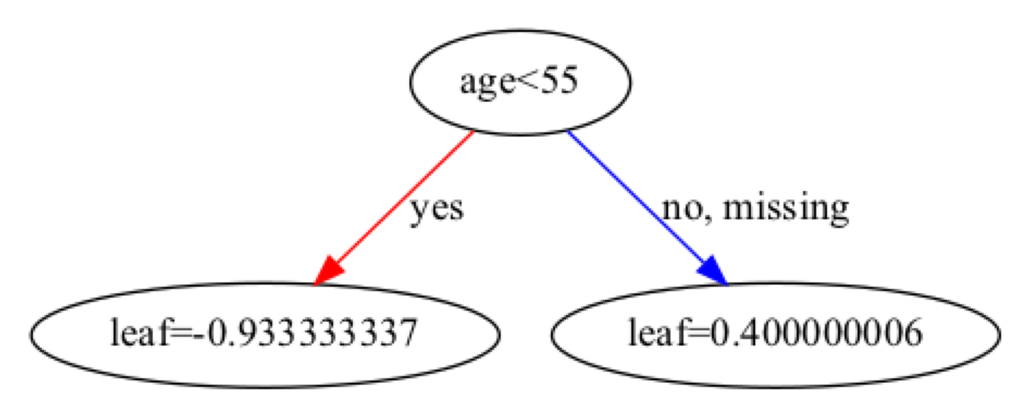

In [30]:
xgboost.plot_tree(model, num_trees=0)

In [31]:
model.get_split_value_histogram('age', as_pandas=True)

,SplitValue,Count
0,55.5,1.0


In [32]:
vals = df['age']
levels = np.unique(vals)

In [34]:
levels[:-1]

array([20, 22, 23, 25, 34, 36, 43, 44, 45, 47, 49, 54, 55, 56])

In [35]:
thresholds = (levels[:-1] + levels[1:]) / 2 if len(levels) > 1 else levels

In [36]:
thresholds

array([21. , 22.5, 24. , 29.5, 35. , 39.5, 43.5, 44.5, 46. , 48. , 51.5,
       54.5, 55.5, 61.5])

In [37]:
eta = 1.0
lambda_ = 0

In [38]:
G_left = df[df['age'] < 55].sum()['grad_0']

In [39]:
H_left = df[df['age'] < 55].sum()['hess_0']

In [40]:
weight_left = eta * (-(G_left / (H_left + lambda_)))

In [43]:
print('сумма градиентов в левом листе первого дерева', G_left)
print('сумма гессианов в левом листе первого дерева', H_left)
print('вес левого листа первого дерева', round(weight_left,3))

сумма градиентов в левом листе первого дерева 3.5
сумма гессианов в левом листе первого дерева 3.75
вес левого листа первого дерева -0.933


In [44]:
G_right = df[df['age'] >= 55].sum()['grad_0']
H_right = df[df['age'] >= 55].sum()['hess_0']

In [45]:
weight_right = eta * (-(G_right / (H_right + lambda_)))

In [46]:
print(G_right)
print(H_right)
print(weight_right)

-0.5
1.25
0.4


In [47]:
df['h_0'] = np.where(df['age'] < 55, -0.93333333337, 0.4000000006)

In [48]:
df

,age,response,const,grad_0,hess_0,h_0
0,23,0,0.5,0.5,0.25,-0.933333
1,45,0,0.5,0.5,0.25,-0.933333
2,44,0,0.5,0.5,0.25,-0.933333
3,20,0,0.5,0.5,0.25,-0.933333
4,49,0,0.5,0.5,0.25,-0.933333
5,56,1,0.5,-0.5,0.25,0.400000
6,55,1,0.5,-0.5,0.25,0.400000
7,43,1,0.5,-0.5,0.25,-0.933333
8,23,0,0.5,0.5,0.25,-0.933333
9,67,0,0.5,0.5,0.25,0.400000


In [49]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [50]:
base_score = .5

In [51]:
df['proba_0'] = sigmoid(np.log(base_score / (1 - base_score)) + df['h_0'])

In [52]:
df

,age,response,const,grad_0,hess_0,h_0,proba_0
0,23,0,0.5,0.5,0.25,-0.933333,0.282249
1,45,0,0.5,0.5,0.25,-0.933333,0.282249
2,44,0,0.5,0.5,0.25,-0.933333,0.282249
3,20,0,0.5,0.5,0.25,-0.933333,0.282249
4,49,0,0.5,0.5,0.25,-0.933333,0.282249
5,56,1,0.5,-0.5,0.25,0.400000,0.598688
6,55,1,0.5,-0.5,0.25,0.400000,0.598688
7,43,1,0.5,-0.5,0.25,-0.933333,0.282249
8,23,0,0.5,0.5,0.25,-0.933333,0.282249
9,67,0,0.5,0.5,0.25,0.400000,0.598688


In [53]:
pr = model.predict(dtrain)
model_info = model.get_dump()[0]

In [54]:
print(pr, '\n\n', model_info)

[0.28224894 0.28224894 0.28224894 0.28224894 0.28224894 0.59868765
 0.59868765 0.28224894 0.28224894 0.59868765 0.28224894 0.28224894
 0.28224894 0.28224894 0.28224894 0.28224894 0.28224894 0.59868765
 0.59868765 0.28224894] 

 0:[age<55] yes=1,no=2,missing=2
	1:leaf=-0.933333337
	2:leaf=0.400000006



In [57]:
def LogLoss(fact, proba):
    logloss = (-1 / len(proba)) * np.sum(
        fact * np.log(proba) + (1 - fact) * np.log(1 - proba)
    )
    return logloss

In [58]:
LogLoss(df['response'],df['proba_0'])

0.6036448453035165

In [59]:
from sklearn.metrics import log_loss
print(log_loss(df['response'], df['proba_0']))

0.6036448453035164


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

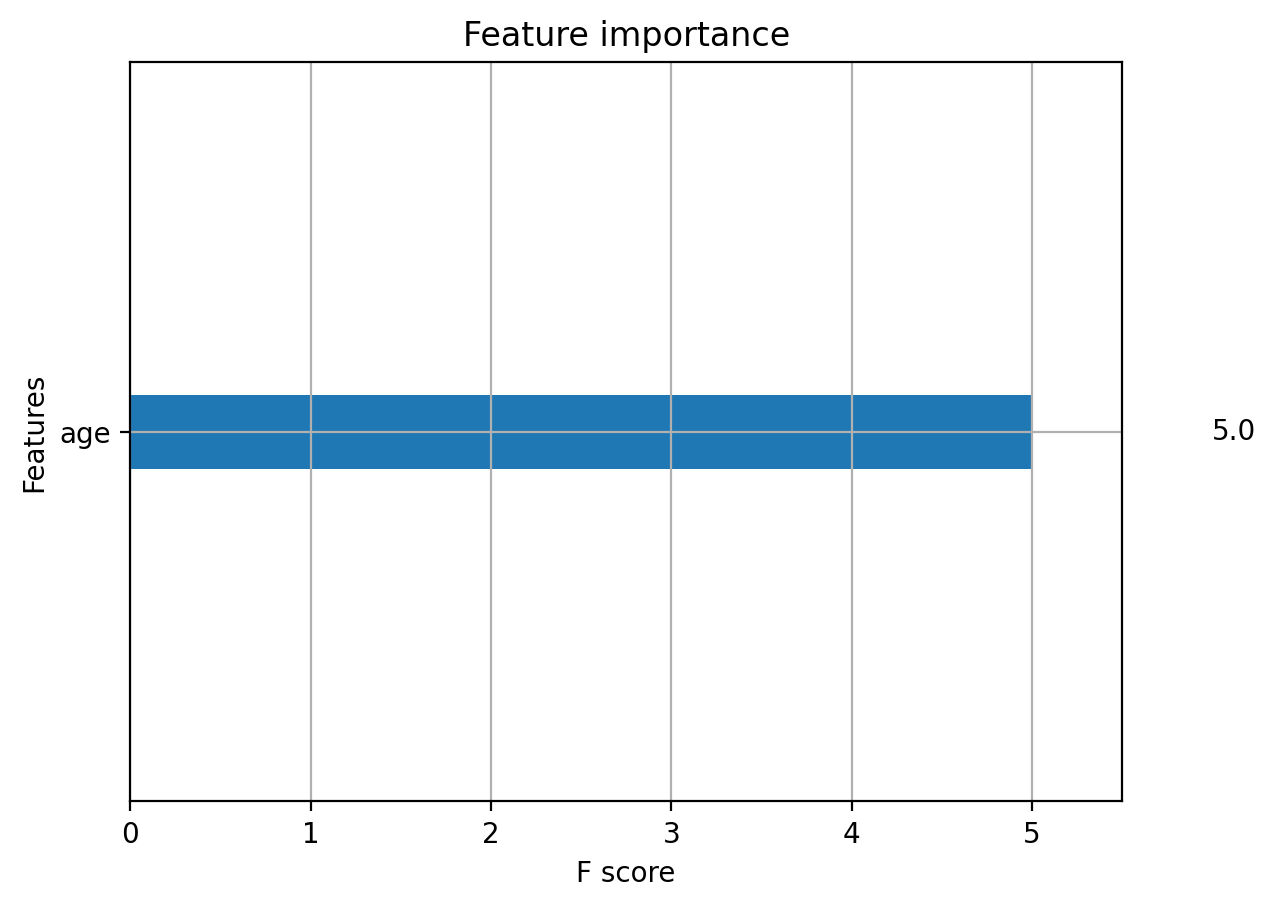

In [61]:
xgboost.plot_importance(model, importance_type='cover')

In [62]:
cover = sum(df['const'] * (1 - df['const']))
cover

5.0

In [64]:
model = xgboost.train(params=params, num_boost_round=2, dtrain=dtrain)

In [65]:
pr = model.predict(dtrain)

In [66]:
print(pr)

[0.41287592 0.1725412  0.1725412  0.41287592 0.1725412  0.44166934
 0.44166934 0.41287592 0.41287592 0.44166934 0.1725412  0.41287592
 0.41287592 0.41287592 0.1725412  0.41287592 0.41287592 0.44166934
 0.44166934 0.41287592]


In [67]:
for line in model.get_dump():
    print(line)

0:[age<55] yes=1,no=2,missing=2
	1:leaf=-0.933333337
	2:leaf=0.400000006

0:[age<44] yes=1,no=2,missing=2
	1:leaf=0.581244171
	2:leaf=-0.634389997



In [68]:
grad_1 = df['proba_0'] - df['response']
hess_1 = df['proba_0'] * (1 - df['proba_0'])

In [69]:
df['grad_1'] = grad_1
df['hess_1'] = hess_1

In [70]:
df

,age,response,const,grad_0,hess_0,h_0,proba_0,grad_1,hess_1
0,23,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584
1,45,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584
2,44,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584
3,20,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584
4,49,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584
5,56,1,0.5,-0.5,0.25,0.400000,0.598688,-0.401312,0.240261
6,55,1,0.5,-0.5,0.25,0.400000,0.598688,-0.401312,0.240261
7,43,1,0.5,-0.5,0.25,-0.933333,0.282249,-0.717751,0.202584
8,23,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584
9,67,0,0.5,0.5,0.25,0.400000,0.598688,0.598688,0.240261


In [71]:
eta = 1.0
lambda_ = 0

In [72]:
G_left2 = df[df['age'] < 44].sum()['grad_1']
H_left2 = df[df['age'] < 44].sum()['hess_1']

In [73]:
weight_left2 = eta * (-(G_left2 / (H_left2 + lambda_)))

In [74]:
G_left2

-1.1775105696516812

In [75]:
H_left2

2.025844771905521

In [76]:
weight_left2

0.5812442226479713

In [77]:
G_right2 = df[df['age'] >= 44].sum()['grad_1']
H_right2 = df[df['age'] >= 44].sum()['hess_1']

In [78]:
weight_right2 = eta * (- (G_right2 / (H_right2 + lambda_)))

In [79]:
G_right2

1.4046830164572017

In [80]:
H_right2

2.214226114518142

In [81]:
weight_right2

-0.6343900504320841

In [82]:
df['h_1'] = np.where(df['age'] < 44, 0.581244171, -0.624389997)

In [83]:
df

,age,response,const,grad_0,hess_0,h_0,proba_0,grad_1,hess_1,h_1
0,23,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,0.581244
1,45,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,-0.624390
2,44,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,-0.624390
3,20,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,0.581244
4,49,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,-0.624390
5,56,1,0.5,-0.5,0.25,0.400000,0.598688,-0.401312,0.240261,-0.624390
6,55,1,0.5,-0.5,0.25,0.400000,0.598688,-0.401312,0.240261,-0.624390
7,43,1,0.5,-0.5,0.25,-0.933333,0.282249,-0.717751,0.202584,0.581244
8,23,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,0.581244
9,67,0,0.5,0.5,0.25,0.400000,0.598688,0.598688,0.240261,-0.624390


In [84]:
base_score = 0.5

In [85]:
df['proba_1'] = sigmoid(
    np.log(base_score / (1 - base_score)) + (df['h_0'] + df['h_1'])
)

In [87]:
df

,age,response,const,grad_0,hess_0,h_0,proba_0,grad_1,hess_1,h_1,proba_1
0,23,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,0.581244,0.412876
1,45,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,-0.624390,0.173974
2,44,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,-0.624390,0.173974
3,20,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,0.581244,0.412876
4,49,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,-0.624390,0.173974
5,56,1,0.5,-0.5,0.25,0.400000,0.598688,-0.401312,0.240261,-0.624390,0.444137
6,55,1,0.5,-0.5,0.25,0.400000,0.598688,-0.401312,0.240261,-0.624390,0.444137
7,43,1,0.5,-0.5,0.25,-0.933333,0.282249,-0.717751,0.202584,0.581244,0.412876
8,23,0,0.5,0.5,0.25,-0.933333,0.282249,0.282249,0.202584,0.581244,0.412876
9,67,0,0.5,0.5,0.25,0.400000,0.598688,0.598688,0.240261,-0.624390,0.444137


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

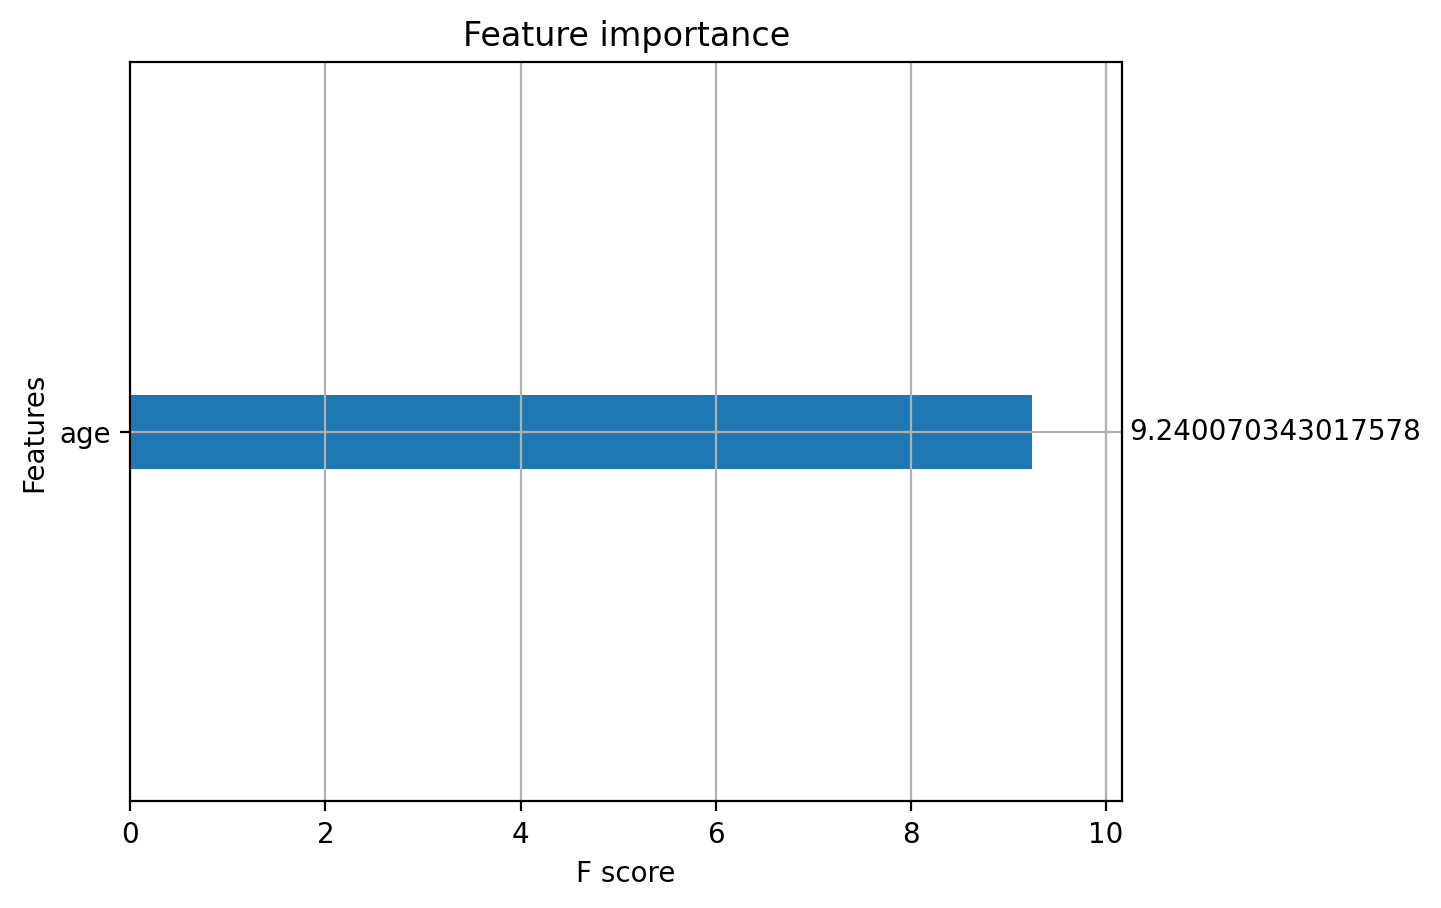

In [88]:
xgboost.plot_importance(model, importance_type='total_cover')

In [91]:
total_cover = (sum(df['const'] * (1 - df['const']))) + (
    sum(df['proba_0'] * (1 - df['proba_0']))
)

In [95]:
total_cover

9.240070886423663

In [96]:
G_total2 = df['grad_1'].sum()
H_total2 = df['hess_1'].sum()

In [97]:
gamma = 0
score_left = (G_left ** 2) / (H_left + lambda_)
score_right = (G_right ** 2) / (H_right + lambda_)
G_total = df['grad_0'].sum()
H_total = df['hess_0'].sum()
score_total = (G_total ** 2) / (H_total + lambda_)
gain_split = (score_left + score_right) - score_total - gamma
gain_split

1.6666666666666667

In [98]:
gamma = 0
score_total2 = (G_total2 ** 2) / (H_total2 + lambda_)
score_left2 = (G_left2 ** 2) / (H_left2 + lambda_)
score_right2 = (G_right2 ** 2) / (H_right2 + lambda_)
gain_split2 = (score_left2 + score_right2) - score_total2 - gamma
total_gain = gain_split + gain_split2
total_gain

3.2300334776469755

In [99]:
gain = (gain_split + gain_split2) / 2

In [100]:
gain

1.6150167388234877

In [101]:
model.get_score(importance_type='total_cover')

{'age': 9.240070343017578}

In [102]:
model.get_score(importance_type='cover')

{'age': 4.620035171508789}

In [103]:
model.get_score(importance_type='total_gain')

{'age': 3.2300333976745605}

In [104]:
model.get_score(importance_type='gain')

{'age': 1.6150166988372803}

In [105]:
model.get_score(importance_type='weight')

{'age': 2.0}

In [106]:
params = {
    'max_depth': 1,
    'eta': 1.0,
    'objective': 'binary:logistic',
    'lambda':0,
    'seed':42,
    'base_score':.3
}

In [107]:
model = xgboost.train(params=params, num_boost_round=2, dtrain= dtrain)

In [108]:
pr = model.predict(dtrain)

In [109]:
pr

array([0.41786543, 0.15039323, 0.15039323, 0.41786543, 0.15039323,
       0.4640077 , 0.4640077 , 0.41786543, 0.41786543, 0.4640077 ,
       0.15039323, 0.41786543, 0.41786543, 0.41786543, 0.15039323,
       0.41786543, 0.41786543, 0.4640077 , 0.4640077 , 0.41786543],
      dtype=float32)

In [110]:
for line in model.get_dump():
    print(line)

0:[age<55] yes=1,no=2,missing=2
	1:leaf=-0.158730209
	2:leaf=1.42857134

0:[age<44] yes=1,no=2,missing=2
	1:leaf=0.674485743
	2:leaf=-0.72549212



In [111]:
base_score = .3
leaf_weight_for_less_than_55 = -0.158730209
leaf_weight_for_55_and_more = 1.42857134

In [112]:
leaf_weight_for_less_than_44 = 0.674485743
leaf_weight_for_44_and_more = -0.72549212

In [113]:
prediction_for_obs_0 = sigmoid(
    np.log(base_score / (1 - base_score)) + (leaf_weight_for_less_than_55 + leaf_weight_for_less_than_44)
)

In [114]:
prediction_for_obs_1 = sigmoid(
    np.log(base_score / (1 - base_score)) + (leaf_weight_for_less_than_55 + leaf_weight_for_44_and_more)
)

In [115]:
prediction_for_obs_0

0.4178653987797429

In [116]:
prediction_for_obs_1

0.1503932341296568

In [121]:
params = {
    'max_depth': 1,
    'eta': 0.5,
    'objective': 'binary:logistic',
    'lambda':0,
    'seed':42,
    'base_score':.3
}
model = xgboost.train(params=params, num_boost_round=2, dtrain= dtrain)

In [122]:
model_info = model.get_dump()[0]

In [123]:
model_info

'0:[age<55] yes=1,no=2,missing=2\n\t1:leaf=-0.0793651044\n\t2:leaf=0.714285672\n'

In [125]:
params = {
    'max_depth': 1,
    'eta': 0.5,
    'objective': 'binary:logistic',
    'lambda':1.0,
    'seed':42,
    'base_score':.3
}
model = xgboost.train(params=params, num_boost_round=2, dtrain= dtrain)
model_info = model.get_dump()[0]
model_info

'0:[age<55] yes=1,no=2,missing=2\n\t1:leaf=-0.060240984\n\t2:leaf=0.365853637\n'